# DM-38610: March 10th exposure time 

* obs ticket https://jira.lsstcorp.org/browse/SITCOM-685 "Medium density Field: study of the atmosphere impact by changing the exposure time"
* analysis ticket https://jira.lsstcorp.org/browse/SITCOM-719 "Atmosphere Impact on the WFS measurement"
* data processing https://jira.lsstcorp.org/browse/DM-38610 "Analyze March 10th auxTel summit run impact of atmosphere dataset" 
* relevant notebook with an analysis of 20211104 dataset where extended exposure time was simulated by stacking exposures  https://github.com/suberlak/AOS/blob/main/AOS_AuxTel_test_data_211104.ipynb 


All the data has been processed, but with the transpose... Run it without the transpose:

In [1]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline
import os

import subprocess
from lsst.daf.butler import Butler

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval


from galsim.zernike import zernikeRotMatrix

from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from astropy.time import Time, TimeDelta
import pandas as pd
from lsst_efd_client import EfdClient

from galsim.zernike import zernikeRotMatrix
from astropy.table import Table

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
def line(x,b, m):
    return b + m*x 

# Find CWFS pairs

In [3]:
input_collections = ['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook']

butler = Butler(
    "/repo/embargo",
    collections=input_collections,
    instrument='LATISS'
)


records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs=20230310"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
# Save record information for each pair and sequence numbers for easy location later.
pairs = []
seq_nums = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') and
        record0.group_id == record1.group_id and
        not record0.physical_filter.startswith("empty")
    ):
        pairs.append((record0, record1))
        #print(record0.seq_num,record1.seq_num, record0.observation_reason , record1.observation_reason)
        seq_nums.append(record0.seq_num)
        
# this only stores the first seqNum in each pair 
seq_nums = np.array(seq_nums)

exp_nums = [int(f'20230310{seq_num+1:05d}') for seq_num in seq_nums]

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


In [4]:
# select a subset of all CWFS pairs that pertain to this test
exp_pairs = []
for pair in pairs:
    if "exposure_time" in pair[0].observation_reason:
        exp_pairs.append(pair)

Run (**only once**)  Zernike retrieval **with** transpose, using Bryce's postISR data:

In [ ]:
repo_dir = '/sdf/data/rubin/repo/embargo/'
input_collection = ['u/brycek/latiss_wep_test/run_all']
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, 
                                              inputs=input_collection, 
                                              output=output_collection)
path_to_pipeline_yaml = os.path.join(os.getcwd(), 'latissWepPipeline_230310_getZernikes_withTranspose.yaml' ) 
                                     
                                     
# Load pipeline from file
pipeline = Pipeline.from_uri(path_to_pipeline_yaml)

data_query = f"exposure in {tuple(exp_nums)}"
executor = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butlerRW)
quanta = executor.run(True)

Compare the results **with** vs **without** transpose: 

In [5]:
# test getting results.. 

output_collection = 'u/scichris/latiss_230310_run/wep_no_transpose_'
butler1 = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler2 = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)




Test: "Exposure Time" Obs Reason Prefix: "intra/extra_aos_exposure_time"
seqNums: "215-228",  ticket: SITCOM-719

In [6]:
intra_seq_nums = []
times = []
for pair in exp_pairs:
    intra_seq_nums.append(pair[0].seq_num)
    times.append(pair[0].exposure_time)

In [7]:
zernikes1 = []
zernikes2 = []
for seq_num in intra_seq_nums:
    zernikes1.append(
        butler1.get(
            "zernikeEstimateAvg", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        ))
    zernikes2.append(
        butler2.get(
            "zernikeEstimateAvg", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        ))
    
zernikes1 = np.array(zernikes1)
zernikes2 = np.array(zernikes2)


Show the donuts  - what do they look like ? 

In [8]:
stamps1 = []
stamps2 = []

for seq_num in intra_seq_nums:
    stamps1.append(
        butler1.get(
            "donutStampsExtra", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        ))
            
    stamps2.append(
        butler2.get(
            "donutStampsExtra", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        ))
    

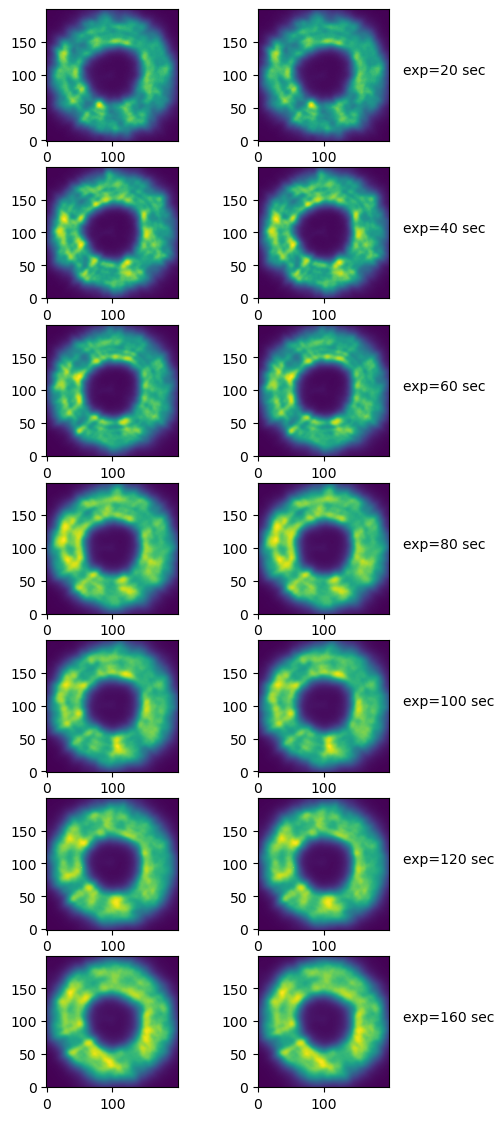

In [13]:
fig,ax = plt.subplots(len(stamps1), 2, figsize=(5,14))
for i in range(len(stamps1)):
    ax[i,0].imshow(stamps1[i][0].stamp_im.image.array, origin='lower')
    ax[i,1].imshow(stamps2[i][0].stamp_im.image.array, origin='lower')
    ax[i,1].text(220,100,f'exp={int(times[i])} sec')
plt.savefig()

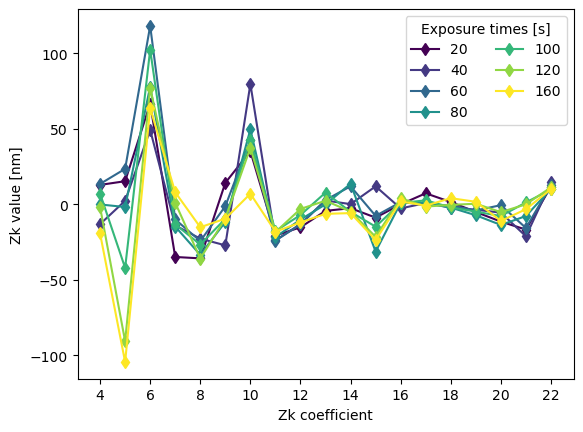

In [70]:
import matplotlib.lines as mlines
import matplotlib as mpl


zernikes  = zernikes1
nlines = len(zernikes)
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis



fig,ax = plt.subplots(1,1)
for i in range(len(zernikes)):
    color = cmap(color_idx[i])
    ax.plot(np.arange(4,23), 1000*zernikes[i], '-d', label=f'{int(times[i])}',
            color=color)
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'exp {times[i]} ')
ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Zk coefficient')
ax.set_ylabel('Zk value [nm]')
ax.legend(title='Exposure times [s]', bbox_to_anchor=[1, 1.0], ncol=2)

Plot strength of each element of the polynomial expansion as  a function of time ... I see that 160 sec has much weaker Z10 than 20 sec, so let's look at that : 

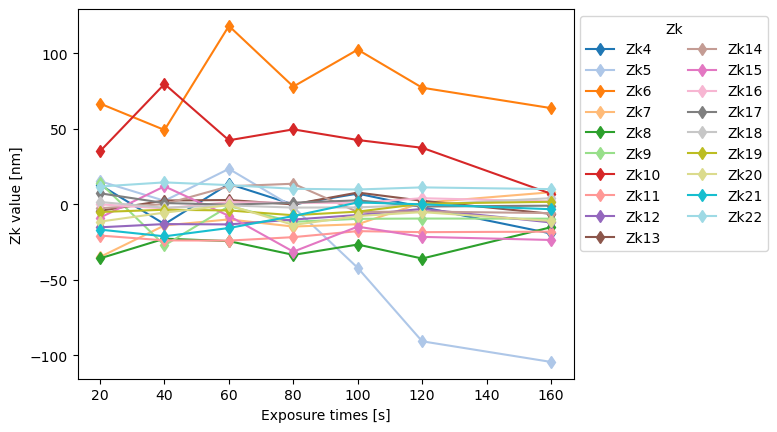

In [71]:
import matplotlib.lines as mlines
import matplotlib as mpl
nlines = 19
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.tab20

fig,ax = plt.subplots(1,1)

for j in range(19):
    color = cmap(color_idx[j])
    ax.plot(times,   1000*zernikes[:,j], '-d', label=f'Zk{j+4}',
            color=color)
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'zk {j} ')
#ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Exposure times [s]')
ax.set_ylabel('Zk value [nm]')
ax.legend(title='Zk', bbox_to_anchor=[1, 1.0], ncol=2)

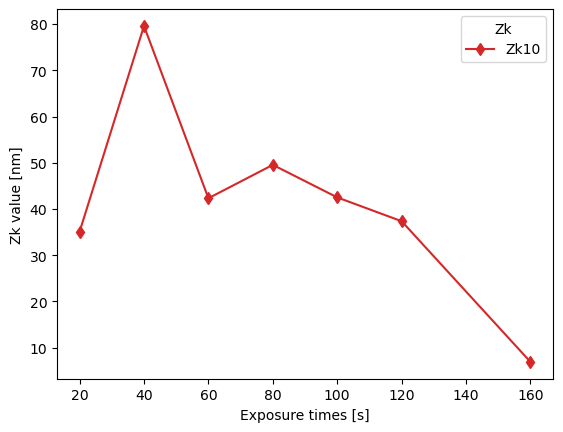

In [72]:
import matplotlib.lines as mlines
import matplotlib as mpl
nlines = 19
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.tab20

fig,ax = plt.subplots(1,1)

j=6
color = cmap(color_idx[j])
ax.plot(times,   1000*zernikes[:,j], '-d', label=f'Zk{j+4}',
        color=color)
line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                             )
ax_legend_handles.append(f'zk {j} ')
#ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Exposure times [s]')
ax.set_ylabel('Zk value [nm]')
ax.legend(title='Zk', bbox_to_anchor=[1, 1.0], ncol=2)

In [30]:
#Zk --> waves --> FWHM contribution 

# calculate coefficients 
import galsim
import numpy as np
zDicAnnular = {}
zDicList4_37 = []
for j in range(4, 37):
    z = galsim.zernike.Zernike([0]*j+[1], R_inner=0.61)
    zkAnnular = np.sqrt(np.sum(z.gradX.coef**2) + np.sum(z.gradY.coef**2))
    zDicAnnular[j] =  zkAnnular
    zDicList4_37.append(zkAnnular)
    #print(f"{j:>2}   {zkAnnular:>6.3f}")
    
rms = zDicList4_37[:19]



0.9819883549746393 20.0
0.9787732195199949 40.0
0.9672868033784644 60.0
0.9784735001463591 80.0
0.971821268465473 100.0
0.9682518926752136 120.0
0.9697559619409765 160.0


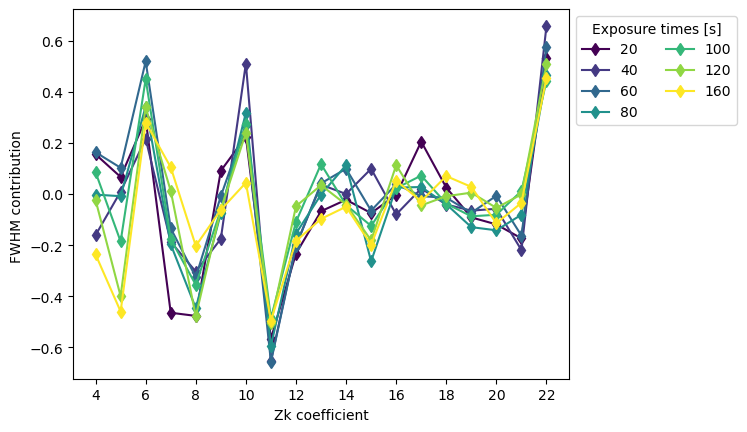

In [47]:
# this converts the Zernikes to nanometers 
# to FWHM contribution, multipltying by the RMS coefficient calculated  above 



import matplotlib.lines as mlines
import matplotlib as mpl
nlines = len(zernikes1)
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis

fig,ax = plt.subplots(1,1, dpi=150)
for i in range(len(zernikes1)):
    color = cmap(color_idx[i])

    zkNm = 1000*zernikes1[i] # convert to nm 
    waves = zkNm / 750. # convert to waves 
    fwhm = waves * rms  # convert to FWHM contribution 
    
    strehl = np.square(1-0.5*np.sum(np.square(waves)))
    
    print(strehl, times[i])
    ax.plot(np.arange(4,23), fwhm, '-d', label=f'{int(times[i])}',
            color=color)
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'exp {times[i]} ')
ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Zk coefficient')
ax.set_ylabel('FWHM contribution ')
ax.legend(title='Exposure times [s]', bbox_to_anchor=[1, 1.0], ncol=2)




"The ratio of the intensity at the Gaussian image point (the origin of the
reference sphere is the point of maximum intensity in the observation plane)
in the presence of aberration, divided by the intensity that would be obtained
if no aberration were present, is called the **Strehl ratio**, the Strehl definition,
or the Strehl intensity. " We calculated it here  https://github.com/suberlak/AOS/blob/main/AOS_AuxTel_test_data_210608_434-471.ipynb 

In [46]:
np.square(1-0.5*np.sum(np.square(waves)))

0.9697559619409765

Perhaps the problem here is that we only estimate Zk4:22, i.e. I don't have zk1,zk2, zk3... They are simply not considered by ts_wep - can I calculate some other form of contributuion to Strehl ratio that would be useful ? 
    

In [ ]:
# zks0_24_waves = zks[434]/750
# zks0_24_waves_squared = np.square(zks0_24_waves)
# variance = np.sum(zks0_24_waves_squared[1:])
# strehl = np.square(1-0.5*variance)


In [ ]:
# This is a total contribution to Strehl ratio 
L2 = np.power(np.sum(np.square(fwhm)),0.5)

In [38]:
# Calculate total variance in each set of Zernikes 

variance = np.array([])
varlist = []
for i in range(len(zernikes1)):
    varlist.append(np.var(zernikes1[i]))



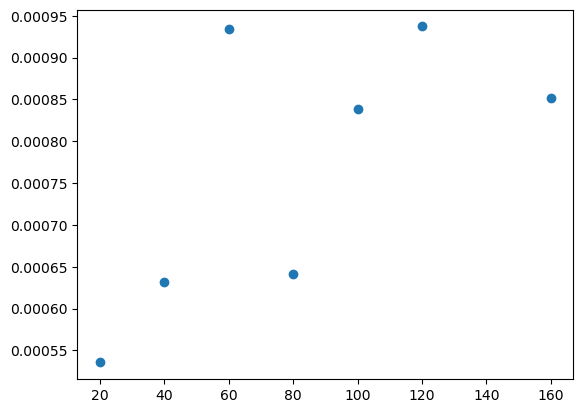

In [41]:
plt.scatter(times, varlist)  

From the slack thread https://lsstc.slack.com/archives/C9BEJU1T3/p1636906023107600?thread_ts=1635474144.029800&cid=C9BEJU1T3 :

* convert zernike amplitudes to waves by dividing all fitted coefficients by 500 nm. Let’s call the resulting 22 element data vector ZW_j for Zernike in Waves.
* Omit the first four elements, which correspond to Noll indices 1,2, 3., and 4 That should be the aberrations that remain after the system is put back at the correct focus. That leaves us with 22-4=18 remaining ZW elements.
* Compute each element’s FWHM contribution, FWHM_j =(JMC_j*ZW_j), where JMC= Josh Meyers Coefficient that encodes the RMS slope of the corresponding Zernike for one wave of amplitude.
* Compute the net effect by computing the norm of the 18 element FWHM_j vector.

Do this for each Aux Tel donut image, so we can understand the impact of coma, astigmatism, etc.

In [ ]:
nrows = 19
ncols = nrows
fig,ax  = plt.subplots(ncols, nrows, figsize=(30,30))

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        if i>=j: 
            #print(f'row{i} col{j}, x=Zk{j+4} vs y=Zk{i+4}')
            ax[i,j].scatter(zernikes[:,j], zernikes[:,i],c=times)
            #ax[i,j].set_title(f'Zk{j+4} vs {i+4}')
        else:
            ax[i,j].axis('off')
            
row=18
for j in range(ncols):
    ax[row,j].set_xlabel(f'Zk{j+4}')
    
col = 0
for i in range(nrows):
    ax[i, col].set_ylabel(f'Zk{i+4}')

Make a simulated optical PSF : https://galsim-developers.github.io/GalSim/_build/html/psf.html?highlight=opticalpsf#galsim.OpticalPSF. This demo gives an example of using it (plus convolving this PSF with atmospheric effects and a bunch of other PSFs): https://galsim-developers.github.io/GalSim/_build/html/tutorials.html#demo-3. You can do a simpler version with just the optical PSF, though.



In [2]:
import sys
import os
import math
import galsim

In [3]:
#Take zernikes for the 20 sec exposure for instance: 
zk_waves_4_22 = (1000*zernikes[0]) / 750  # zk_microns--> zk_nm --> zk_waves 
zk_waves_1_22 = np.pad(zk_waves_4_22, [4,0]) 
zk_waves_1_22   # so that [0] is unused, and [1] is zk1,  i.e. Piston 

lam = 750  # nm
diam = 2*1.2    # meters
lam_over_diam = (lam * 1e-9) / diam  # radians
lam_over_diam *= 206265  # Convert to arcsec
        
# auxTel data from 
#https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
optics = galsim.OpticalPSF(lam = 750, # nm 
                           diam = 1.2, # m   instApertureDiameter: 1.2
                           aberrations = zk_waves_1_22,
                          annular_zernike=True,
                          obscuration=0.3525, # fractional  oscuration 
                           # (inner_radius / outer_radius of primary mirror)  instObscuration: 0.3525)
                          )
atmos_fwhm=2.1         # arcsec
atmos_e = 0.13         #
atmos_beta = 0.81      # radians

# Define the atmospheric part of the PSF.
# Note: the flux here is the default flux=1.
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm)
# For the PSF shape here, we use ellipticity rather than axis ratio.
# And the position angle can be either degrees or radians.  Here we chose radians.
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)
psf = galsim.Convolve([atmos, optics])
fwhm = psf.calculateFWHM()

NameError: name 'zernikes' is not defined

Run for all zernikes, and plot as a function of exposure time: 

In [ ]:
def calc_psf_fwhm(zk_4_22_microns):
    lam = 750   # nm 
        
    #Take zernikes for the 20 sec exposure for instance: 
    zk_waves_4_22 = (1000*zk_4_22_microns) / lam  # zk_microns--> zk_nm --> zk_waves 
    zk_waves_1_22 = np.pad(zk_waves_4_22, [4,0]) 
    zk_waves_1_22   # so that [0] is unused, and [1] is zk1,  i.e. Piston 

    diam = 2*1.2    # meters
    lam_over_diam = (lam * 1e-9) / diam  # radians
    lam_over_diam *= 206265  # Convert to arcsec

    # auxTel data from 
    #https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
    optics = galsim.OpticalPSF(lam = 750, # nm 
                               diam = 1.2, # m   instApertureDiameter: 1.2
                               aberrations = zk_waves_1_22,
                              annular_zernike=True,
                              obscuration=0.3525, # fractional  oscuration 
                               # (inner_radius / outer_radius of primary mirror)  instObscuration: 0.3525)
                              )
    atmos_fwhm=2.1         # arcsec
    atmos_e = 0.13         #
    atmos_beta = 0.81      # radians

    # Define the atmospheric part of the PSF.
    # Note: the flux here is the default flux=1.
    atmos = galsim.Kolmogorov(fwhm=atmos_fwhm)
    # For the PSF shape here, we use ellipticity rather than axis ratio.
    # And the position angle can be either degrees or radians.  Here we chose radians.
    atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)
    psf = galsim.Convolve([atmos, optics])
    fwhm = psf.calculateFWHM()
    
    return fwhm

In [ ]:
psf_fwhm = []
for i in range(len(zernikes)):
    psf_fwhm.append(calc_psf_fwhm(zernikes[i]))

In [ ]:
plt.scatter(times, psf_fwhm)
# rad -> arcsec and sigma -> FWHM 
plt.title('FWHM[asec] = $\sqrt{\sum(Z_{j}[\mathrm{waves}]*f_{j})^{2} * \lambda[m] * 206265 * 2.35}$')
plt.ylabel('FWHM [asec]')
#'     (np.sum((waves*rms)**2.) * 750e-9 * 206265 * 2.35))

In [ ]:

        screen= OpticalScreen(diam=2*1.2, aberrations =  zk_waves_1_22,
                     annular_zernike=True, obscuration = 0.61,
                     lam_0 = 750)